In [1]:
using TrajectoryOptimization
using Plots
using MeshCat
using GeometryTypes
using CoordinateTransformations
using FileIO

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [69]:
### Solver options ###
opts = SolverOptions()
opts.square_root = false
opts.verbose = true
opts.cache=true
# opts.c1=1e-4
opts.c2 = 2.0
# opts.mu_al_update = 10.0
opts.eps_constraint = 1e-3
opts.eps_intermediate = 1e-5
opts.eps = 1e-5
opts.outer_loop_update = :uniform
opts.τ = 0.1
# opts.iterations_outerloop = 250
# opts.iterations = 1000

0.1

In [70]:
# Model
n = 13 # states (quadrotor w/ quaternions)
m = 4 # controls
model = Model(Dynamics.quadrotor_dynamics!,n,m)
model_euler = Model(Dynamics.quadrotor_dynamics_euler!,12,m)

TrajectoryOptimization.Model(TrajectoryOptimization.Dynamics.quadrotor_dynamics_euler!, 12, 4)

In [84]:
# Objective and constraints
Qf = 100.0*eye(n)
Q = (0.1)*eye(n)
R = (0.001)*eye(m)
tf = 5.0
dt = 0.05

Qf_euler = 100.0*eye(12)
Q_euler = (0.1)*eye(12)

# -initial state
x0 = zeros(n)
quat0 = eul2quat([0.0; 0.0; 0.0]) # ZYX Euler angles
x0[4:7] = quat0
x0

x0_euler = zeros(12)

# -final state
xf = zeros(n)
xf[1:3] = [20.0;20.0;0.0] # xyz position
quatf = eul2quat([0.0; 0.0; 0.0]) # ZYX Euler angles
xf[4:7] = quatf
xf

xf_euler = zeros(12)
xf_euler[1:3] = [20.0;20.0;0.0]

# -control limits
u_min = -10.0
u_max = 10.0

# -obstacles
quad_radius = 3.0
sphere_radius = 1.0

n_spheres = 4
spheres = ([5.0;9.0;9.0;15.0;],[5.0;9.0;9.0;15.0],[0.0;0.0;4.0;0.0],[sphere_radius;sphere_radius;sphere_radius])
function cI(x,u)
    [TrajectoryOptimization.sphere_constraint(x,spheres[1][1],spheres[2][1],spheres[3][1],spheres[4][1]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][2],spheres[2][2],spheres[3][2],spheres[4][2]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][3],spheres[2][3],spheres[3][3],spheres[4][3]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][4],spheres[2][4],spheres[3][4],spheres[4][4]+quad_radius);
     -x[3]]
end

# -constraint that quaternion should be unit
function cE(x,u)
    [x[4]^2 + x[5]^2 + x[6]^2 + x[7]^2 - 1.0]
end

obj_uncon = UnconstrainedObjective(Q, R, Qf, tf, x0, xf)
obj_uncon_euler = UnconstrainedObjective(Q_euler, R, Qf_euler, tf, x0_euler, xf_euler)
obj_con = TrajectoryOptimization.ConstrainedObjective(obj_uncon, u_min=u_min, u_max=u_max, cI=cI, cE = cE)
obj_con_euler = TrajectoryOptimization.ConstrainedObjective(obj_uncon_euler, u_min=u_min, u_max=u_max,cI=cI);

In [85]:
# Solver
solver = Solver(model,obj_con,integration=:rk4,dt=dt,opts=opts)

solver_uncon_euler = Solver(model_euler,obj_uncon_euler,integration=:rk4,dt=dt,opts=opts)
solver_euler = Solver(model_euler,obj_con_euler,integration=:rk4,dt=dt,opts=opts)


# - Initial control and state trajectories
U = ones(solver.model.m, solver.N);
# X_interp = line_trajectory(solver)

In [86]:
### Solve ###
# results,stats = solve(solver,U)

results_uncon_euler, stats_uncon_euler = solve(solver_uncon_euler,U)
results_euler, stats_euler = solve(solver_euler,U);

Solving Unconstrained Problem...
Outer loop 1 (begin)
Cost (1): 69921.60993415084

--Iteration: 1-(1)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 39364.33532061653
- Expected improvement: 39293.97351147882
- Actual improvement: 30557.27461353431
- (z = 0.777658044804446, α = 0.125)
--(v1 = 139711.90581859145, v2 = 139711.90581859057)--

--Iteration: 1-(2)--
Non-finite values in rollout
New cost: 9892.332995651288
- Expected improvement: 49127.375582214605
- Actual improvement: 29472.002324965237
- (z = 0.5999099682343885, α = 0.25)
--(v1 = 78603.8009315433, v2 = 78603.8009315436)--

--Iteration: 1-(3)--
New cost: 59.210340600039146
- Expected improvement: 29498.351053185925
- Actual improvement: 9833.12265505125
- (z = 0.33334482450635955, α = 0.5)
--(v1 = 19665.567368790566, v2 = 19665.56736879072)--

--Iteration: 1-(4)--
New cost: 59.0124586509941
- Expected improvement: 0.6157354846254226
- Actual improvement: 0.19788194904504763
- (z = 0.3213749312587164, 

Non-finite values in rollout
Non-finite values in rollout
New cost: 58.84568777863914
- Expected improvement: 0.008324029199785943
- Actual improvement: 0.004535836824956618
- (z = 0.544908807512744, α = 0.015625)
--(v1 = 0.2622709507871017, v2 = 0.2622709507871011)--

--Iteration: 1-(34)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 58.84133342793886
- Expected improvement: 0.00800271490892391
- Actual improvement: 0.004354350700282339
- (z = 0.5441091866744819, α = 0.015625)
--(v1 = 0.2521470789765564, v2 = 0.2521470789765572)--

--Iteration: 1-(35)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 58.83715141563889
- Expected improvement: 0.007696833555987981
- Actual improvement: 0.004182012299963844
- (z = 0.5433419171069801, α = 0.015625)
--(v1 = 0.24250946342559052, v2 = 0.24250946342559077)--

--Iteration: 1-(36)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New c

New cost: 58.71375977040266
- Expected improvement: 0.0003213113484386587
- Actual improvement: 0.00012957329465734801
- (z = 0.4032639845650667, α = 0.25)
--(v1 = 0.0005140981575018499, v2 = 0.00051409815750187)--

--Iteration: 1-(65)--
New cost: 58.71372744891212
- Expected improvement: 0.00011051445068208741
- Actual improvement: 3.2321490543552045e-5
- (z = 0.2924639297762969, α = 0.5)
--(v1 = 7.36763004547278e-5, v2 = 7.36763004547192e-5)--

--Iteration: 1-(66)--
New cost: 58.713713835894275
- Expected improvement: 3.419125450055038e-5
- Actual improvement: 1.361301784186253e-5
- (z = 0.39814326911121084, α = 0.25)
--(v1 = 5.4706007200880965e-5, v2 = 5.470600720087915e-5)--

--Iteration: 1-(67)--
New cost: 58.71370974878816
- Expected improvement: 1.4973127443268846e-5
- Actual improvement: 4.087106113104255e-6
- (z = 0.2729627546809941, α = 0.5)
--(v1 = 9.98208496217915e-6, v2 = 9.982084962179392e-6)--

--iLQR (inner loop) cost eps criteria met at iteration: 67

Unconstrained sol

New cost: 63.43504843659403
- state+control cost: 63.43504843659403
- Max constraint violation: 2.471656236067382
- Expected improvement: 0.030412152020877246
- Actual improvement: 0.0026361972102719733
- (z = 0.08668236330208676, α = 0.125)
--(v1 = 0.10813209607423037, v2 = 0.10813209607422891)--

--Iteration: 1-(24)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.43500776821712
- state+control cost: 63.43500776821712
- Max constraint violation: 2.479959883369485
- Expected improvement: 0.0187676687659126
- Actual improvement: 4.066837691141245e-5
- (z = 0.002166938122079272, α = 0.0625)
--(v1 = 0.14130950600216563, v2 = 0.14130950600216233)--

--Iteration: 1-(25)--
Non-finite values in rollout
New cost: 63.378324542214614
- state+control cost: 63.378324542214614
- Max constraint violation: 2.5053436033783267
- Expected improvement: 0.09667543097069915
- Actual improvement: 0.056683226002505194
- (z = 0.5863250407405478, α = 0.25)
--(v1 = 0.15468068955311795, 

--Iteration: 1-(44)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.26632076355915
- state+control cost: 63.26632076355915
- Max constraint violation: 2.585622700690557
- Expected improvement: 0.0004876250634926698
- Actual improvement: 9.315790246233746e-5
- (z = 0.1910441227017402, α = 0.00390625)
--(v1 = 0.06217314428220916, v2 = 0.06217314428225932)--

--Iteration: 1-(45)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.266234518052634
- state+control cost: 63.266234518052634
- Max constraint violation: 2.585610495033599
- Expected improvement: 0.0004896083933698511
- Actual improvement: 8.624550651603613e-5
- (z = 0.17615201798815183, α = 0.00390625)
--(v1 = 0.062426022700168046, v2 = 0.0624260227002609)--

--Iteration: 1-(46)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.26516934687345
- state+control cost: 63.26516934687345
- Max constraint violation: 2.585528885118677
- Expected improvement: 0.0005379191368774236
- Actual improvement: 6.58748517352592e-5
- (z = 0.12246236881933092, α = 0.00390625)
--(v1 = 0.06858573648715703, v2 = 0.0685857364872138)--

--Iteration: 1-(64)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.26509949513034
- state+control cost: 63.26509949513034
- Max constraint violation: 2.5855305410067952
- Expected improvement: 0.0005403766347062836
- Actual improvement: 6.985174310614184e-5
- (z = 0.12926492120465027, α = 0.00390625)
--(v1 = 0.06889907224146079, v2 = 0.06889907224153806)--

--Iteration: 1-(65)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout

New cost: 63.26293924278201
- state+control cost: 63.26293924278201
- Max constraint violation: 2.5856281697130115
- Expected improvement: 0.0005655153141320997
- Actual improvement: 0.00016995254441809493
- (z = 0.30052686491597896, α = 0.00390625)
--(v1 = 0.07210430277618933, v2 = 0.07210430277617608)--

--Iteration: 1-(83)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.26276229798799
- state+control cost: 63.26276229798799
- Max constraint violation: 2.5856316070272083
- Expected improvement: 0.000566088126592539
- Actual improvement: 0.0001769447940205282
- (z = 0.31257464290165227, α = 0.00390625)
--(v1 = 0.07217733747931662, v2 = 0.0721773374792651)--

--Iteration: 1-(84)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.26257967098825
- state+control cost: 63.26257967098825
- Max constraint violation: 2.5856380856800385
- Expected improvement: 0.0005660963829617684
- Actual

New cost: 63.258592562393865
- state+control cost: 63.258592562393865
- Max constraint violation: 2.585831931022547
- Expected improvement: 0.001105783655918042
- Actual improvement: 1.768089203579848e-5
- (z = 0.015989467687618764, α = 0.0078125)
--(v1 = 0.0702215481339578, v2 = 0.07022154813400242)--

--Iteration: 1-(103)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.258519247223305
- state+control cost: 63.258519247223305
- Max constraint violation: 2.5858335524565934
- Expected improvement: 0.0011183745781732403
- Actual improvement: 7.331517056030634e-5
- (z = 0.06555511184817861, α = 0.0078125)
--(v1 = 0.07102112049918603, v2 = 0.071021120499372)--

--Iteration: 1-(104)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.25839068929861
- state+control cost: 63.25839068929861
- Max constraint violation: 2.5858356984823025
- Expected improvement: 0.001127034376644919
- Actual i

New cost: 63.23727412732719
- state+control cost: 63.23727412732719
- Max constraint violation: 2.5885090160373885
- Expected improvement: 0.00046963670458136173
- Actual improvement: 0.00010841131709327101
- (z = 0.2308408095783523, α = 0.00390625)
--(v1 = 0.05987959352420999, v2 = 0.059879593524303054)--

--Iteration: 1-(125)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.23714157356697
- state+control cost: 63.23714157356697
- Max constraint violation: 2.5883692259414275
- Expected improvement: 0.00045354035044004563
- Actual improvement: 0.0001325537602170357
- (z = 0.29226453630515115, α = 0.00390625)
--(v1 = 0.05782727705532675, v2 = 0.05782727705576689)--

--Iteration: 1-(126)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.23696124856362
- state+control cost: 63.23696124856362
- Max constraint violation: 2.5883879795078144
- Expected improvement: 0.0004293956949464084
- Actual improvement: 0.0001803

New cost: 63.94266301828246
- state+control cost: 63.94266301828246
- Max constraint violation: 2.4967951481132022
- Expected improvement: 0.004053064554466906
- Actual improvement: 0.00207260823624722
- (z = 0.5113681779292132, α = 0.00390625)
--(v1 = 0.516773616034131, v2 = 0.5167736160340566)--

--Iteration: 2-(6)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.94203063270423
- state+control cost: 63.94203063270423
- Max constraint violation: 2.4848883612841526
- Expected improvement: 0.004119076373192912
- Actual improvement: 0.0006323855782284227
- (z = 0.1535260628678821, α = 0.00390625)
--(v1 = 0.5251902513493593, v2 = 0.5251902513493547)--

--Iteration: 2-(7)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.94124435759783
- state+control cost: 63.94124435759783
- Max constraint violation

New cost: 63.93207954868526
- state+control cost: 63.93207954868526
- Max constraint violation: 2.3804067956963806
- Expected improvement: 0.000992647237072054
- Actual improvement: 0.000446379412082365
- (z = 0.4496858454963526, α = 0.0009765625)
--(v1 = 0.50773954598052, v2 = 0.5077395459805905)--

--Iteration: 2-(24)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.931736496894864
- state+control cost: 63.931736496894864
- Max constraint violation: 2.377690899497729
- Expected improvement: 0.0009952097340420098
- Actual improvement: 0.00034305179039506584
- (z = 0.3447030094870283, α = 0.0009765625)
--(v1 = 0.5090502644306508, v2 = 0.509050264430774)--

--Iteration: 2-(25)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.92034173833081
- state+control cost: 63.92034173833081
- Max constraint v

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.85505056348289
- state+control cost: 63.85505056348289
- Max constraint violation: 2.123686298474455
- Expected improvement: 0.0006237306825593498
- Actual improvement: 0.0003011971649513612
- (z = 0.48289618159469233, α = 0.0009765625)
--(v1 = 0.3190385483842718, v2 = 0.3190385521820922)--

--Iteration: 2-(42)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 63.85488554684098
- state+control cost: 63.85488554684098
- Max constraint violation: 2.1219619546713844
- Expected improvement: 0.0005457348606949718
- Actual improvement: 0.0001650166419082666
- (z = 0.3023751161839367, α = 0.0009765625)
--(v1 = 0.2791436474508095, v2 = 0.27914365441644723)--

--Iteration: 2-(43)--
Non-finite values in rol

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 91.59952298006829
- state+control cost: 91.59952298006829
- Max constraint violation: 2.078208951318329
- Expected improvement: 0.20781368178993187
- Actual improvement: 0.3021535312230128
- (z = 1.4539636111564793, α = 0.001953125)
--(v1 = 53.096598081231335, v2 = 53.096681979507345)--

--Iteration: 4-(7)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 91.38301224181788
- state+control cost: 91.38301224181788
- Max constraint violation: 2.068899516072875
- Expected improvement: 0.22686535750438533
- Actual improvement: 0.21651073825040612
- (z = 0.9543578

New cost: 91.0214423978705
- state+control cost: 91.0214423978705
- Max constraint violation: 2.037639467678453
- Expected improvement: 0.3880486336393582
- Actual improvement: 0.0625453461399843
- (z = 0.1611791428136099, α = 0.00390625)
--(v1 = 49.47695564904482, v2 = 49.47698093901562)--

--Iteration: 4-(21)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 90.99943018695178
- state+control cost: 90.99943018695178
- Max constraint violation: 2.036396416457988
- Expected improvement: 0.027292083887040942
- Actual improvement: 0.0220122109187173
- (z = 0.8065419632236044, α = 0.0001220703125)
--(v1 = 111.77473122306614, v2 = 111.77474665318232)--

--Iteration: 4-(22)--
Non-finite values in rollout
Non-finite 

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 88.47558983566671
- state+control cost: 88.47558983566671
- Max constraint violation: 1.9285263664023553
- Expected improvement: 0.0569367850651957
- Actual improvement: 0.07185226891650132
- (z = 1.261965684121901, α = 0.00048828125)
--(v1 = 58.27481340225043, v2 = 58.27482523641682)--

--Iteration: 4-(36)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 88.43793724285672
- state+control cost: 88.43793724285672
- Max constraint violation: 1.9264227620306364
- Expected improvement: 0.048209954959233234
- Actual improvement: 0.03765259280999089
- (z = 0.7810128186560278, α = 0.00048828125)
--(v1 = 49.34290066580780

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 87.67278421848567
- state+control cost: 87.67278421848567
- Max constraint violation: 1.8833347432054808
- Expected improvement: 0.02046113658247859
- Actual improvement: 0.005279467450989728
- (z = 0.25802415372715287, α = 0.000244140625)
--(v1 = 41.89417965044506, v2 = 41.89417664958509)--

--Iteration: 4-(51)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 87.65908094723895
- state+control cost: 87.65908094723895
- Max constraint violation: 1.8823195611448398
- Expected improvement: 0.022999520752164573
- Actual improvement:

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 87.07803676453787
- state+control cost: 87.07803676453787
- Max constraint violation: 1.8590581489699094
- Expected improvement: 0.011223663027383242
- Actual improvement: 0.004974251074855829
- (z = 0.4431931948348558, α = 0.0001220703125)
--(v1 = 45.9665126130119, v2 = 45.966517451615765)--

--Iteration: 4-(65)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 87.07574443470295
- state+control cost: 87.07574443470295
- Max constraint violation: 1.8568713351421096
- Expected improvement: 0.0486052279

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 86.21016498816813
- state+control cost: 86.21016498816813
- Max constraint violation: 1.7506721421010454
- Expected improvement: 0.048237650190347106
- Actual improvement: 0.03456979469082455
- (z = 0.7166558601924261, α = 0.00048828125)
--(v1 = 49.37124674118628, v2 = 49.37124603730582)--

--Iteration: 4-(79)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 86.20618149121947
- state+control cost: 86.20618149121947
- Max constraint violation: 1.7505698859153238
- Expected improvement: 0.0024402103810652544
- Actual improvement: 0.003983496948663401
- (z = 1.6324399648379648, α = 3.0517578125e-5)
--(v1 = 39.9791868

New cost: 85.0966188915957
- state+control cost: 85.0966188915957
- Max constraint violation: 1.6855204276544065
- Expected improvement: 0.0015445737360507941
- Actual improvement: 0.0025955467581297853
- (z = 1.6804291679632894, α = 3.0517578125e-5)
--(v1 = 25.30552382813798, v2 = 25.305524411799425)--

--Iteration: 4-(93)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 85.09239540341082
- state+control cost: 85.09239540341082
- Max constraint violation: 1.6849574138186938
- Expected improvement: 0.014388776998585819
- Actual improvement: 0.004223488184877056
- (z = 0.29352655790635684, α = 0.000244140625)
--(v1 = 29.461022660669073, v2 = 29.461022452472676)--

--Iteration: 4-(94)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rol

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 84.71694644449965
- state+control cost: 84.71694644449965
- Max constraint violation: 1.6716991935169645
- Expected improvement: 0.055665318077736836
- Actual improvement: 0.025204578833566416
- (z = 0.45278783457894056, α = 0.0009765625)
--(v1 = 28.472837351348765, v2 = 28.472836559354455)--

--Iteration: 4-(108)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 84.71498668662075
- state+control cost: 84.71498668662075
- Max constraint violation: 1.6711548439656276
- Expected improvement: 0.014069466693852268
- Actual improvement: 0.0019597578789074532
- (z = 0.1392915539409735, α = 0.000244140625)
--(v1 = 28.8072

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 83.47879423695446
- state+control cost: 83.47879423695446
- Max constraint violation: 1.6185354618567445
- Expected improvement: 0.008725820231151322
- Actual improvement: 0.01328084787813566
- (z = 1.5220171314924427, α = 6.103515625e-5)
--(v1 = 71.47755668975623, v2 = 71.47755659937164)--

--Iteration: 4-(124)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 83.40706307066186
- state+control cost: 83.40706307066186
- Max constraint violation: 1.6162951795895975
- Expected improvement: 0.04700964259525172
- Actual improvement: 

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 74.4873302737206
- state+control cost: 74.4873302737206
- Max constraint violation: 1.1902623909136452
- Expected improvement: 0.01985621243574381
- Actual improvement: 0.028571923178446923
- (z = 1.4389412518076046, α = 0.0009765625)
--(v1 = 10.156462345104067, v2 = 10.156464124686359)--

--Iteration: 4-(140)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 74.48645306402
- state+control cost: 74.48645306402
- Max constraint violation: 1.190231266387098
- Expected improvement: 0.0004986782929794774


New cost: 73.92804281731749
- state+control cost: 73.92804281731749
- Max constraint violation: 1.161688299319037
- Expected improvement: 0.002943861764954168
- Actual improvement: 0.0013458186560768581
- (z = 0.45716095507555554, α = 3.0517578125e-5)
--(v1 = 48.23075927105495, v2 = 48.23075894513621)--

--Iteration: 4-(154)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 73.61505053278671
- state+control cost: 73.61505053278671
- Max constraint violation: 1.1207718160444617
- Expected improvement: 0.6226021966931826
- Actual improvement: 0.3129922845307789
- (z = 0.5027163190126375, α = 0.015625)
--(v1 = 19.616758450672748, v2 = 19.61675798458217)--

--Iteration: 4-(155)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 73.5224119542144
- state+control cost: 73.52241195421

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 139.8494090011062
- state+control cost: 139.8494090011062
- Max constraint violation: 1.0768184454562366
- Expected improvement: 0.6267734516031886
- Actual improvement: 0.4108473866915574
- (z = 0.655495834484811, α = 0.001953125)
--(v1 = 160.14122777490502, v2 = 160.14122778177068)--

--Iteration: 5-(3)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 139.84945217283348
- state+control cost: 139.84945217283348
- Max constraint violation: 1.0

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 132.3440290481404
- state+control cost: 132.3440290481404
- Max constraint violation: 1.009040543655587
- Expected improvement: 1.1321576563942866
- Actual improvement: 1.1527813069259025
- (z = 1.018216235534986, α = 0.00390625)
--(v1 = 144.35230383162963, v2 = 144.35230383079454)--

--Iteration: 5-(17)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 127.98584221946861
- state+control cost: 127.98584221946861
- Max constraint violation: 0.9733330005171617
- Expected improvement: 4.405021050666033
- Actual improvement: 4.358186828671805
- (z = 0.9893679913318129, α = 0.015625)
--(v1 = 138.79204787328712, v2 = 138.79204787366047)--

--Iteration: 5-(18)--
Non-finite value

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 84.83253844677189
- state+control cost: 84.83253844677189
- Max constraint violation: 0.4848504015632926
- Expected improvement: 6.767139852609661e-5
- Actual improvement: 2.1124368728919762e-5
- (z = 0.31216096000695803, α = 1.9073486328125e-6)
--(v1 = 17.739617259590347, v2 = 17.739617257470414)--

--Iteration: 5-(34)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 84.50479443970275
- state+control cost: 84.50479443970275
- Max constraint violation: 0.47944728817601145
- Expected improvement: -0.00025298749734310326
- Actual improvement: -0.0001520015362501681
- (z = 0.6008262773714175, α = 7.62939453125e-6)
--(v1 = -16.579662133093972, v2 = -16.57966213777838)--

--Iteration: 5-(48)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in roll

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 187.72471973754014
- state+control cost: 187.72471973754014
- Max constraint violation: 0.42845945180165934
- Expected improvement: 0.4936798994721139
- Actual improvement: 0.6049624400033906
- (z = 1.2254143639436603, α = 0.0009765625)
--(v1 = 252.51750939944944, v2 = 252.517509399427)--

--Iteration: 6-(8)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 186.82196840099056
- state+control cost: 186.82196840099056
- Max constraint violation: 0.4275415984994986
- Expected improvement: 0.47123214590014084
- Actual improvement: 0.902751336549585
- (z = 1.9157

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 493.4870438897161
- state+control cost: 493.4870438897161
- Max constraint violation: 0.2473358476055072
- Expected improvement: 3.4712609618606574
- Actual improvement: 3.29629229698304
- (z = 0.9495950702640833, α = 0.001953125)
--(v1 = 886.9105590506828, v2 = 886.9105590504788)--

--Iteration: 7-(9)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 487.18176752331897
- state+control cost: 487.18176752331897
- Max constraint violation: 0.24514446165406056
- Expected improvement: 6.5880297039641675
- Actual improvement: 6.305276366397152
- (z = 0.9570807433674933, α = 0.00390625)
--(v1

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 525.2113040044514
- state+control cost: 525.2113040044514
- Max constraint violation: 0.2504787101024064
- Expected improvement: 11.588615171334574
- Actual improvement: 9.42291259876481
- (z = 0.8131180869715293, α = 0.0078125)
--(v1 = 735.9219804928134, v2 = 735.9219804927144)--

--Iteration: 7-(26)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 524.3151149895016
- state+control cost: 524.3151149895016
- Max constraint violation: 0.2501459852621455
- Expected improvement: 1.092489312614411
- Actual improvement: 0.8961890149498686
- (z = 0.820318335934307, α = 0.0009765625)
--(v1 = 558.8088163238872, v2 = 558.8

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 494.66882405016713
- state+control cost: 494.66882405016713
- Max constraint violation: 0.2420010281295184
- Expected improvement: 3.649117321846427
- Actual improvement: 0.3336303686737665
- (z = 0.09142769038320532, α = 0.0625)
--(v1 = 27.475706893902508, v2 = 27.475706893902515)--

--Iteration: 7-(41)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 494.65697162373334
- state+control cost: 494.65697162373334
- Max constraint violation: 0.2419860898246995
- Expected improvement: 0.04875652023309643

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 486.60077752809326
- state+control cost: 486.60077752809326
- Max constraint violation: 0.2407509359839004
- Expected improvement: 0.7115737200877748
- Actual improvement: 0.2605725292760894
- (z = 0.3661918954004471, α = 0.015625)
--(v1 = 22.42004582676558, v2 = 22.420045826765577)--

--Iteration: 7-(58)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 486.4703809543984
- state+control cost: 486.4703809543984
- Max constraint violation: 0.24065651470158933
- Expected improvement: 2.8477279872311483
- Actual improvement: 0.13039657369483848
- (z = 0.04578968717501117, α = 0.0625)
--(v1 = 21.441716609740414, v2 = 21.441716609740375)--

--Iteration: 7-(59)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite val

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 469.1268871534454
- state+control cost: 469.1268871534454
- Max constraint violation: 0.23858272899863842
- Expected improvement: 0.2836771827053616
- Actual improvement: 0.0879741168671444
- (z = 0.31012052512703436, α = 0.0078125)
--(v1 = 18.01460062575443, v2 = 18.01460062575488)--

--Iteration: 7-(77)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 469.0918676064165
- state+control cost: 469.0918676064165
- Max constraint violation: 0.23812191217891332
- Expected improvement: 1.5445591803556247
- Actual improvement: 0.035019547028923625
- (z = 0.022672842500512415, α = 0.015625)
--(v1 = 48.66549540566645, v2 = 48.66549540566646)--

--Iteration: 7-(78)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite v

- Expected improvement: 5.077349448753916
- Actual improvement: 0.7399578848919077
- (z = 0.14573704102117854, α = 0.5)
--(v1 = 3.3848996325024197, v2 = 3.384899632502993)--

--Iteration: 7-(96)--
Non-finite values in rollout
New cost: 462.59402413191407
- state+control cost: 462.59402413191407
- Max constraint violation: 0.23653673218462146
- Expected improvement: 0.7802623913925757
- Actual improvement: 0.4427043868916485
- (z = 0.5673788609771778, α = 0.125)
--(v1 = 2.7742662805067178, v2 = 2.7742662805086815)--

--Iteration: 7-(97)--
New cost: 461.70365290528775
- state+control cost: 461.70365290528775
- Max constraint violation: 0.23649388980276242
- Expected improvement: 1.5873597708707803
- Actual improvement: 0.8903712266263142
- (z = 0.5609133121333181, α = 0.25)
--(v1 = 2.539775633393267, v2 = 2.539775633393174)--

--Iteration: 7-(98)--
Non-finite values in rollout
New cost: 461.4187214256591
- state+control cost: 461.4187214256591
- Max constraint violation: 0.23653226695834

Non-finite values in rollout
Non-finite values in rollout
New cost: 460.14877336533846
- state+control cost: 460.14877336533846
- Max constraint violation: 0.23584193576295753
- Expected improvement: 0.49751129886121187
- Actual improvement: 0.12590853135657198
- (z = 0.2530767273924688, α = 0.0625)
--(v1 = 3.745967426719697, v2 = 3.7459674267199636)--

--Iteration: 7-(117)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 460.03459228364403
- state+control cost: 460.03459228364403
- Max constraint violation: 0.23580743380018276
- Expected improvement: 0.5148870233525121
- Actual improvement: 0.11418108169442576
- (z = 0.22175948609264687, α = 0.0625)
--(v1 = 3.8767964111239532, v2 = 3.876796411138298)--

--Iteration: 7-(118)--
New cost: 459.9766471446334
- state+control cost: 459.9766471446334
- Max constraint violation: 0.23581963426101282
- Expected improvement: 0.8152693366775098
- Actual improvement: 0.057945139010655566
- (z = 0.07107484165515293, α = 0.25)
--

Non-finite values in rollout
New cost: 339995.7412710988
- state+control cost: 339995.7412710988
- Max constraint violation: 0.23582441355510042
- Expected improvement: 0.046623866730682306
- Actual improvement: 0.019312170625198632
- (z = 0.4142121188007268, α = 0.0009765625)
--(v1 = 23.848130576093638, v2 = 23.84813057607999)--

--Iteration: 10-(12)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 339995.4025855407
- state+control cost: 339995.4025855407
- Max constraint violation: 0.23582407800499894
- Expected improvement: 0.9510352601964661
- Actual improvement: 0.33868555806111544
- (z = 0.35612302954061803, α = 0.0078125)
--(v1 = 60.39442520565467, v2 = 60.39442520565299)--

--Iteration: 10-(13)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 339995.40433233464
- state+control cost: 339995.4043

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.39894043760063e6
- state+control cost: 3.39894043760063e6
- Max constraint violation: 0.23582739895417149
- Expected improvement: -2.3524066620009854
- Actual improvement: -2.545906693674624
- (z = 1.0822561994910544, α = 0.03125)
--(v1 = -36.49794578619711, v2 = -36.49794578619705)--

--Iteration: 11-(4)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3989404386827215e6
- state+control cost: 3.3989404386827215e6
- Max constraint violation: 0.23582739845252476
- Expected improvement: -0.000700232792390146
- Actual improvement: -0.0010820915922522545
- (z = 1.5453312155785897, α = 0.001953125)
--(v1 = -0.1789101609437651, v2 = -0.17891016095347823)--

--Iteration: 11-(5)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398940419535567e6
- state+control cost: 3.398940419535567e6
- Max constraint violation: 0.2358273

New cost: 3.3988306027540974e7
- state+control cost: 3.3988306027540974e7
- Max constraint violation: 0.23582725324404308
- Expected improvement: 1.4886280464699038
- Actual improvement: 0.5788986831903458
- (z = 0.38888067745541405, α = 0.0078125)
--(v1 = 94.53365082698804, v2 = 94.53365082698303)--

--Iteration: 12-(12)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.39883060012564e7
- state+control cost: 3.39883060012564e7
- Max constraint violation: 0.23582725279749717
- Expected improvement: 0.0260168007995816
- Actual improvement: 0.02628457546234131
- (z = 1.010292374716726, α = 0.00048828125)
--(v1 = 26.62820196702978, v2 = 26.628201967157793)--

--Iteration: 12-(13)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398830651872253e7
- state+control cost: 3.398830651872253e7
- Max constrain

Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398821959808742e7
- state+control cost: 3.398821959808742e7
- Max constraint violation: 0.2358269261423338
- Expected improvement: 0.5089669734073671
- Actual improvement: 0.35930947214365005
- (z = 0.7059583252292205, α = 0.00390625)
--(v1 = 64.89427931755904, v2 = 64.89427931749174)--

--Iteration: 12-(31)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3988222218895264e7
- state+control cost: 3.3988222218895264e7
- Max constraint violation: 0.23582692921463533
- Expected improvement: -1.8108978164000133
- Actual improvement: -2.6208078414201736
- (z = 1.4472422561258738, α = 0.00390625)
--(v1 = -230.89299473850474, v2 = -230.89299473842402)--

--Iteration: 12-(32)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398822253751022e7
- state+control cost: 3.

Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398819299862101e7
- state+control cost: 3.398819299862101e7
- Max constraint violation: 0.23582675836013145
- Expected improvement: 1.1358355025143643
- Actual improvement: 0.5855395272374153
- (z = 0.515514373288407, α = 0.001953125)
--(v1 = 290.20707794456655, v2 = 290.20707794468797)--

--Iteration: 12-(49)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398819306502806e7
- state+control cost: 3.398819306502806e7
- Max constraint violation: 0.23582676051128892
- Expected improvement: -0.17840230775868884
- Actual improvement: -0.06640704721212387
- (z = 0.3722319965835173, α = 0.001953125)
--(v1 = -45.581963513736525, v2 = -45.581963513764435)--

--Iteration: 12-(50)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398819406768334e7
- state+control cost:

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.39881931834177e7
- state+control cost: 3.39881931834177e7
- Max constraint violation: 0.23582676760751298
- Expected improvement: -0.09358139486391413
- Actual improvement: -0.11462831497192383
- (z = 1.2249049625581674, α = 0.001953125)
--(v1 = -23.910137597666505, v2 = -23.910137597702487)--

--Iteration: 12-(67)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3988192858027436e7
- state+control cost: 3.3988192858027436e7
- Max constraint violation: 0.23582676539254166
- Expected improvement: 0.30210367750017697
- Actual improvement: 0.3253902643918991
- (z = 1.0770814413264085, α = 0.0009765625)
--(v1 = 154.52617840898824, v2 = 154.52617840883613)--

--Iteration: 12-(68)--
Non-finite values in rollout
Non-finite values i

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3987507105812356e7
- state+control cost: 3.3987507105812356e7
- Max constraint violation: 0.23582387021564344
- Expected improvement: 312.10987168936737
- Actual improvement: 308.9551218599081
- (z = 0.9898921818384551, α = 0.0078125)
--(v1 = 19820.186580459682, v2 = 19820.18658045811)--

--Iteration: 12-(85)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398751938576987e7
- state+control cost: 3.398751938576987e7
- Max constraint violation: 0.23582392513916162
- Expected improvement: -9.07529062103608
- Actual improvement: -12.279957510530949
- (z = 1.3531200292436483, α = 0.001953125)
--(v1 = -2318.745598987214, v2 = -2318.7455989873997)--

--Iteration: 12-(86)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398751128569355e

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398744331058091e7
- state+control cost: 3.398744331058091e7
- Max constraint violation: 0.23582327387217106
- Expected improvement: 14.245055237866568
- Actual improvement: 10.915612757205963
- (z = 0.7662738104510682, α = 0.00390625)
--(v1 = 1816.2722569432372, v2 = 1816.2722569429625)--

--Iteration: 12-(105)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398744329221868e7
- state+control cost: 3.398744329221868e7
- Max constraint violation: 0.2358232745412998
- Expected improvement: 0.011751919030431279
- Actual improvement: 0.01836223155260086
- (z = 1.562487922615222, α = 0.000244140625)
--(v1 = 24.06205564901836, v2 = 24.062055648855335)--

--Iteration: 12-(106)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398744633808779e7
- state+control cost: 3.398744633808779e7
- Max constraint violation: 0.23582329

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398721452141732e7
- state+control cost: 3.398721452141732e7
- Max constraint violation: 0.2358228117171315
- Expected improvement: 32.343051852818064
- Actual improvement: 24.8131016343832
- (z = 0.7671849195709473, α = 0.0078125)
--(v1 = 2053.909153320043, v2 = 2053.909153320054)--

--Iteration: 12-(125)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398721942644835e7
- state+control cost: 3.398721942644835e7
- Max constraint violation: 0.23582284425799216
- Expected improvement: -5.440025708093553
- Actual improvement: -4.905031032860279
- (z = 0.9016558553322055, α = 0.0078125)
--(v1 = -345.46271783490124, v2 = -345.4627178350263)--

--Iteration: 12-(126)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New 

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398756610964321e7
- state+control cost: 3.398756610964321e7
- Max constraint violation: 0.235823932619315
- Expected improvement: -28.68811697113085
- Actual improvement: -35.73083117604256
- (z = 1.2454923832051739, α = 0.0078125)
--(v1 = -1821.8066219186449, v2 = -1821.8066219173681)--

--Iteration: 12-(145)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398756690707712e7
- state+control cost: 3.398756690707712e7
- Max constraint violation: 0.23582395579002835
- Expected improvement: -1.2320770058540471
- Actual improvement: -0.7974339053034782
- (z = 0.6472273254955485, α = 0.0078125)
--(v1 = -78.24166536402583, v2 = -78.24166536104678)--

--Iteration: 12-(146)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3987549397795685e7
- state+control cost: 3.3987549397795685e7
- Max constraint violation: 0.2358239245

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3986774806632765e7
- state+control cost: 3.3986774806632765e7
- Max constraint violation: 0.2358203537564698
- Expected improvement: 1.213412875854185
- Actual improvement: 1.7896967381238937
- (z = 1.4749280922736479, α = 0.001953125)
--(v1 = 310.0281724443656, v2 = 310.02817244452126)--

--Iteration: 12-(165)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398677000887549e7
- state+control cost: 3.398677000887549e7
- Max constraint violation: 0.2358203597258406
- Expected improvement: 4.217261732897914
- Actual improvement: 4.797757275402546
- (z = 1.13764750192674, α = 0.00390625)
--(v1 = 537.7090757338486, v2 = 537.709075733569)--

--Iteration: 12-(166)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398676518549212e7
- sta

Non-finite values in rollout
New cost: 3.397961832398065e7
- state+control cost: 3.397961832398065e7
- Max constraint violation: 0.23579505721332517
- Expected improvement: -0.9047972872369908
- Actual improvement: -0.4023874029517174
- (z = 0.44472657978507096, α = 0.0078125)
--(v1 = -57.4581347057773, v2 = -57.45813470593464)--

--Iteration: 12-(185)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397961919754012e7
- state+control cost: 3.397961919754012e7
- Max constraint violation: 0.23579506467629052
- Expected improvement: -1.1412294311903854
- Actual improvement: -0.8735594674944878
- (z = 0.7654547312044885, α = 0.00390625)
--(v1 = -145.50897276749663, v2 = -145.5089727674109)--

--Iteration: 12-(186)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.39796197196337e7
- state+control cost: 3.39796197196337e7
- Max const

Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397971981448357e7
- state+control cost: 3.397971981448357e7
- Max constraint violation: 0.23579556722612516
- Expected improvement: -1.376539865208634
- Actual improvement: -1.3135231956839561
- (z = 0.9542209629249445, α = 0.001953125)
--(v1 = -351.70727721759454, v2 = -351.70727721766934)--

--Iteration: 12-(205)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3979704532350056e7
- state+control cost: 3.3979704532350056e7
- Max constraint violation: 0.2357955164552692
- Expected improvement: 18.192864736295412
- Actual improvement: 15.282133512198925
- (z = 0.8400069881083942, α = 0.015625)
--(v1 = 573.2151843066622, v2 = 573.2151843066229)--

--Iteration: 12-(206)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397970111871543e7
- state+control cost: 3.397970111871543e7
- Max constraint violation: 0.23579550702962493
- Expected improvement

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397826405637209e7
- state+control cost: 3.397826405637209e7
- Max constraint violation: 0.23578971888026423
- Expected improvement: -115.98808342509193
- Actual improvement: -89.73389116674662
- (z = 0.7736475034066673, α = 0.00390625)
--(v1 = -14788.706294449079, v2 = -14788.706294448002)--

--Iteration: 12-(224)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397826996715155e7
- state+control cost: 3.397826996715155e7
- Max constraint violation: 0.2357897522336927
- Expected improvement: -6.931692895735295
- Actual improvement: -5.91077946126461
- (z = 0.8527180228802694, α = 0.00390625)
--(v1 = -883.8043299900961, v2 = -883.8043299895236)--

--Iteration: 12-(225)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollo

Non-finite values in rollout
New cost: 3.3977918038079396e7
- state+control cost: 3.3977918038079396e7
- Max constraint violation: 0.2357886878332458
- Expected improvement: 26.94632784462107
- Actual improvement: 15.683502845466137
- (z = 0.5820274634785467, α = 0.015625)
--(v1 = 849.0166065505219, v2 = 849.01660655055)--

--Iteration: 12-(244)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3977922600122906e7
- state+control cost: 3.3977922600122906e7
- Max constraint violation: 0.23578870382196015
- Expected improvement: -3.8905515267442787
- Actual improvement: -4.562043510377407
- (z = 1.1725955764927374, α = 0.001953125)
--(v1 = -994.0397070437155, v2 = -994.039707043798)--

--Iteration: 12-(245)--
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397794362220257e7
- state+control cost: 3.397794362220257e7
- Max constraint violation: 0.235788805607406
- Expected improvement: -22.

New cost: 3.3977902386758186e7
- state+control cost: 3.3977902386758186e7
- Max constraint violation: 0.23578820953431645
- Expected improvement: 13.40138172301728
- Actual improvement: 13.086586073040962
- (z = 0.9765102094334313, α = 0.0078125)
--(v1 = 851.0396827515982, v2 = 851.039682752998)--

--Iteration: 12-(265)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3977921076597095e7
- state+control cost: 3.3977921076597095e7
- Max constraint violation: 0.2357882814660286
- Expected improvement: -18.37234159316858
- Actual improvement: -18.689838908612728
- (z = 1.0172812656369399, α = 0.00048828125)
--(v1 = -18804.096103853917, v2 = -18804.09610385513)--

--Iteration: 12-(266)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.39779394661768e7
- state+control cost: 3.39779394661768e7
- Max constr

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.39779927284344e7
- state+control cost: 3.39779927284344e7
- Max constraint violation: 0.2357886274370884
- Expected improvement: 0.1684006429905579
- Actual improvement: 0.044156722724437714
- (z = 0.2622123166531707, α = 6.103515625e-5)
--(v1 = 1379.4538721960212, v2 = 1379.4538721972438)--

--Iteration: 12-(284)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3978028045948185e7
- state+control cost: 3.3978028045948185e7
- Max constraint violation: 0.23578876065045407
- Expected improvement: -33.69845715525602
- Actual improvement: -35.31751378625631
- (z = 1.0480454230750371, α = 0.001953125)
--(v1 = -8609.988647668066, v2 = -8609.988647667897)--

--Iteration: 12-(285)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in 

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3977635620878465e7
- state+control cost: 3.3977635620878465e7
- Max constraint violation: 0.23578693148613894
- Expected improvement: 26.183466368728293
- Actual improvement: 9.619460001587868
- (z = 0.3673868030352421, α = 0.0078125)
--(v1 = 1662.7516007180134, v2 = 1662.751600716454)--

--Iteration: 12-(304)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397759415543667e7
- state+control cost: 3.397759415543667e7
- Max constraint violation: 0.23578678592924796
- Expected improvement: 51.546390463746135
- Actual improvement: 41.465441793203354
- (z = 0.8044295909015595, α = 0.015625)
--(v1 = 1624.1078103038683, v2 = 1624.1078103045104)--

--Iteration: 12-(305)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397763228974557e7


Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397754448620589e7
- state+control cost: 3.397754448620589e7
- Max constraint violation: 0.2357861958021843
- Expected improvement: 2.6295999562721346
- Actual improvement: 2.6133910194039345
- (z = 0.9938359685359979, α = 0.000244140625)
--(v1 = 5384.106231384934, v2 = 5384.106231387959)--

--Iteration: 12-(322)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397753114014147e7
- state+control cost: 3.397753114014147e7
- Max constraint violation: 0.2357861332875686
- Expected improvement: 17.42515556577314
- Actual improvement: 13.346064418554306
- (z = 0.7659079064274714, α = 0.0009765625)
--(v1 = 8912.975571968847, v2 = 8912.97557196753)--

--Iteration: 12-(323)--
Non-finite values in rollout
Non-finite values in rollout


Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397761504421575e7
- state+control cost: 3.397761504421575e7
- Max constraint violation: 0.23578650380948574
- Expected improvement: -39.24652370554802
- Actual improvement: -23.71576227247715
- (z = 0.604276762202116, α = 0.001953125)
--(v1 = -10027.525058739939, v2 = -10027.525058741401)--

--Iteration: 12-(339)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397759651469196e7
- state+control cost: 3.397759651469196e7
- Max constraint violation: 0.23578645006192644
- Expected improvement: 15.091089408871573
- Actual improvement: 18.52952379733324
- (z = 1.227845339412032, α = 0.0009765625)
--(v1 = 7719.099594144836, v2 = 7719.09959414701)--

--Iteration: 12-(340)--

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397863261622087e7
- state+control cost: 3.397863261622087e7
- Max constraint violation: 0.23579041836860704
- Expected improvement: 8.999684518045326
- Actual improvement: 10.105640642344952
- (z = 1.122888321483055, α = 0.00048828125)
--(v1 = 9211.179300335669, v2 = 9211.179300342767)--

--Iteration: 12-(357)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.397867230755015e7
- state+control cost: 3.397867230755015e7
- Max constraint violation: 0.2357905493540038
- Expected improvement: -30.03418451959868
- Actual improvement: -39.69132927805185
- (z = 1.3215384373812928, α = 0.00390625)
--(v1 = -3829.416958514432, v2 = -3829.4169585149602)--

--Iteration: 12-(358)--

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3978783842349425e7
- state+control cost: 3.3978783842349425e7
- Max constraint violation: 0.23579081299954652
- Expected improvement: -5.773586353064265
- Actual improvement: -8.92464005947113
- (z = 1.5457706031770841, α = 0.00048828125)
--(v1 = -5909.267041240325, v2 = -5909.267041242968)--

--Iteration: 12-(374)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.39787449098249e7
- state+control cost: 3.39787449098249e7
- Max constraint violation: 0.2357906740218958
- Expected improvement: 38.631498670055855
- Actual improvement: 38.932524524629116
- (z = 1.0077922385860374, α = 0.001953125)
--(v1 = 9870.385562732088, v2 = 9870.38556273179)--

--Iteration: 12-(375)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398340906459655e7
- state+control cost: 3.398340906459655e7
- Max constraint violation: 0.2358084970428962
- Expected improvement: -21.658554323628515
- Actual improvement: -23.84611038118601
- (z = 1.101001942459796, α = 0.001953125)
--(v1 = -5533.781739389149, v2 = -5533.781739392445)--

--Iteration: 12-(391)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398343185298667e7
- state+control cost: 3.398343185298667e7
- Max constraint violation: 0.23580860661366287
- Expected improvement: -23.97644563127159
- Actual improvement: -22.78839012235403
- (z = 0.9504490562450998, α = 0.00390625)
--(v1 = -3057.043464768513, v2 = -3057.043464768155)--

--Iteration: 12-(392)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollou

Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398619698925088e7
- state+control cost: 3.398619698925088e7
- Max constraint violation: 0.23581620878506726
- Expected improvement: 3.217393373916782
- Actual improvement: 2.997601017355919
- (z = 0.9316862033897668, α = 0.0001220703125)
--(v1 = 13176.83475922632, v2 = 13176.834759224974)--

--Iteration: 12-(407)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398614639063791e7
- state+control cost: 3.398614639063791e7
- Max constraint violation: 0.23581597476347227
- Expected improvement: 76.81000839415825
- Actual improvement: 50.59861297160387
- (z = 0.658750259627001, α = 0.00390625)
--(v1 = 9793.425506069172, v2 = 9793.42550606951)--

--Iteration: 12-(408)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
No

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.3985962785879105e7
- state+control cost: 3.3985962785879105e7
- Max constraint violation: 0.2358121552733472
- Expected improvement: 60.08970956242571
- Actual improvement: 105.863247230649
- (z = 1.761753351805941, α = 0.001953125)
--(v1 = 15352.979360168156, v2 = 15352.979360166704)--

--Iteration: 12-(423)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398596683823939e7
- state+control cost: 3.398596683823939e7
- Max constraint violation: 0.235812189274748
- Expected improvement: -5.054735180686308
- Actual improvement: -4.0523602813482285
- (z = 0.8016958626896886, α = 0.00048828125)
--(v1 = -5173.522690896366, v2 = -5173.5226908945215)--

--Iteration: 12-(424)

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398593658044452e7
- state+control cost: 3.398593658044452e7
- Max constraint violation: 0.23581315531258618
- Expected improvement: 13.299954822687381
- Actual improvement: 15.54064866155386
- (z = 1.1684737932375717, α = 0.00048828125)
--(v1 = 13612.507006495114, v2 = 13612.50700649391)--

--Iteration: 12-(439)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398595283140935e7
- state+control cost: 3.398595283140935e7
- Max constraint violation: 0.23581336040924938
- Expected improvement: -46.97301460228663
- Actual improvement: -16.25096482783556
- (z = 0.3459638468050221, α = 0.0009765625)
--(v1 = -24026.719882735273, v2 = -24026.71988

Non-finite values in rollout
Non-finite values in rollout
New cost: 3.39866312573328e7
- state+control cost: 3.39866312573328e7
- Max constraint violation: 0.23581639842936397
- Expected improvement: 25.7218436460449
- Actual improvement: 31.85290138423443
- (z = 1.238359964493924, α = 0.0009765625)
--(v1 = 13156.735572192763, v2 = 13156.735572197977)--

--Iteration: 12-(455)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398662933173236e7
- state+control cost: 3.398662933173236e7
- Max constraint violation: 0.23581639125940512
- Expected improvement: 2.5590385969936693
- Actual improvement: 1.9256004393100739
- (z = 0.7524702603439621, α = 0.0001220703125)
--(v1 = 10480.54273015983, v2 = 10480.542730156103)--

--Iteration: 12-(456)--
Non-finite values in rollou

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398598972478823e7
- state+control cost: 3.398598972478823e7
- Max constraint violation: 0.23581402783516303
- Expected improvement: -10.099154100727453
- Actual improvement: -13.908347658813
- (z = 1.3771794667249573, α = 0.0009765625)
--(v1 = -5165.722248938717, v2 = -5165.722248948893)--

--Iteration: 12-(471)--
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398584690560063e7
- state+control cost: 3.398584690560063e7
- Max constraint violation: 0.2358132718157666
- Expected improvement: 209.11935948959777
- Actual improvement: 142.8191876038909
- (z = 0.6829553607684761, α = 0.001953125)
--(v1 = 53430.20016963072, v2 = 53430.20016963089)--

--Iteration: 12-(472)--


Excessive output truncated after 524324 bytes.

Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
Non-finite values in rollout
New cost: 3.398606146765778e7
- state+control cost: 3.398606146765778e7
- Max constraint violation: 0.23581427526454668
- Expected improvement: -275.7285204487991


In [74]:
### Results ###
# println("Final position: $(results.X[1:3,end])\n       desired: $(obj_uncon.xf[1:3])\n    Iterations: $(stats["iterations"])\n Max violation: $(max_violation(results.result[results.termination_index]))")
println("Final position (euler): $(results_euler.X[1:3,end])\n       desired: $(obj_uncon_euler.xf[1:3])\n    Iterations: $(stats_euler["iterations"])\n Max violation: $(max_violation(results_euler.result[results_euler.termination_index]))")

Final position (euler): [20.0, 20.0, 2.52278e-7]
       desired: [20.0, 20.0, 0.0]
    Iterations: 240
 Max violation: 0.00020584864786954427


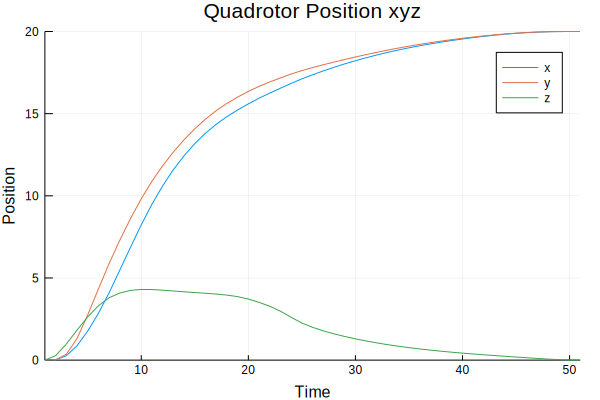

In [75]:
# Position
# plot(results.X[1:3,:]',title="Quadrotor Position xyz",xlabel="Time",ylabel="Position",label=["x";"y";"z"])
plot(results_euler.X[1:3,:]',title="Quadrotor Position xyz",xlabel="Time",ylabel="Position",label=["x";"y";"z"])

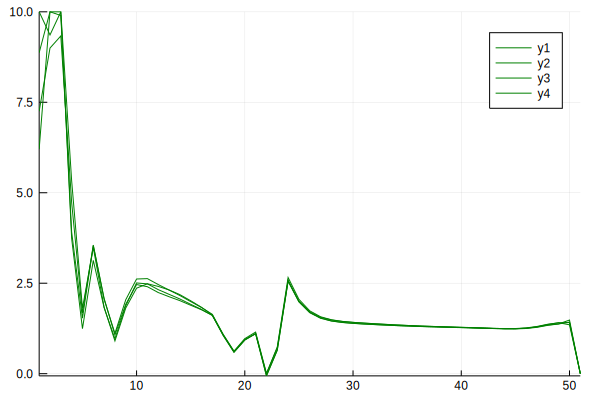

In [76]:
# Control
# plot(results.U[1:m,:]',color="green")
plot(results_euler.U[1:m,:]',color="green")

Quaternion Animation

In [77]:
# ### Visualizer using MeshCat and GeometryTypes ###
# # Set up visualizer
# vis = Visualizer()
# open(vis)

# # Import quadrotor obj file
# urdf_folder = joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf")
# # urdf = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor.urdf")
# obj = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor_base.obj")

# # color options
# green = MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0))
# red = MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0))
# blue = MeshPhongMaterial(color=RGBA(0, 0, 1, 1.0))
# orange = MeshPhongMaterial(color=RGBA(233/255, 164/255, 16/255, 1.0))
# black = MeshPhongMaterial(color=RGBA(0, 0, 0, 1.0))
# black_transparent = MeshPhongMaterial(color=RGBA(0, 0, 0, 0.1))

# # geometries
# robot_obj = load(obj)
# sphere_small = HyperSphere(Point3f0(0), convert(Float32,0.1*quad_radius)) # trajectory points
# sphere_medium = HyperSphere(Point3f0(0), convert(Float32,quad_radius))

# obstacles = vis["obs"]
# traj = vis["traj"]
# target = vis["target"]
# robot = vis["robot"]

# # Set camera location
# settransform!(vis["/Cameras/default"], compose(Translation(25., -5., 10),LinearMap(RotZ(-pi/4))))

# # Create and place obstacles
# for i = 1:n_spheres
#     setobject!(vis["obs"]["s$i"],HyperSphere(Point3f0(0), convert(Float32,spheres[4][i])),red)
#     settransform!(vis["obs"]["s$i"], Translation(spheres[1][i], spheres[2][i], spheres[3][i]))
# end

# # Create and place trajectory
# for i = 1:solver.N
#     setobject!(vis["traj"]["t$i"],sphere_small,blue)
#     settransform!(vis["traj"]["t$i"], Translation(results.X[1,i], results.X[2,i], results.X[3,i]))
# end

# # Create and place initial position
# setobject!(vis["robot"]["ball"],sphere_medium,black_transparent)
# setobject!(vis["robot"]["quad"],robot_obj,black)
# settransform!(vis["robot"],compose(Translation(results.X[1,1], results.X[2,1], results.X[3,1]),LinearMap(quat2rot(results.X[4:7,1]))))

In [78]:
# # Animate quadrotor
# for i = 1:solver.N
#     settransform!(vis["robot"], compose(Translation(results.X[1,i], results.X[2,i], results.X[3,i]),LinearMap(quat2rot(results.X[4:7,i]))))
#     sleep(solver.dt/2)
# end

Euler Angle Animation

In [79]:
### Visualizer using MeshCat and GeometryTypes ###
# Set up visualizer
vis = Visualizer()
open(vis)

Listening on 0.0.0.0:8705...
Could not open browser automatically: could not spawn `start http://127.0.0.1:8705`: no such file or directory (ENOENT)
Please open the following URL in your browser:
http://127.0.0.1:8705


INFO: Serving MeshCat visualizer at http://127.0.0.1:8705


In [80]:
# Import quadrotor obj file
urdf_folder = joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf")
# urdf = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor.urdf")
obj = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor_base.obj")

# color options
green = MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0))
red = MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0))
blue = MeshPhongMaterial(color=RGBA(0, 0, 1, 1.0))
orange = MeshPhongMaterial(color=RGBA(233/255, 164/255, 16/255, 1.0))
black = MeshPhongMaterial(color=RGBA(0, 0, 0, 1.0))
black_transparent = MeshPhongMaterial(color=RGBA(0, 0, 0, 0.1))

# geometries
robot_obj = load(obj)
sphere_small = HyperSphere(Point3f0(0), convert(Float32,0.1*quad_radius)) # trajectory points
sphere_medium = HyperSphere(Point3f0(0), convert(Float32,quad_radius))

obstacles = vis["obs"]
traj = vis["traj"]
target = vis["target"]
robot = vis["robot"]

# Set camera location
settransform!(vis["/Cameras/default"], compose(Translation(25., -5., 10),LinearMap(RotZ(-pi/4))))

# Create and place obstacles
for i = 1:n_spheres
    setobject!(vis["obs"]["s$i"],HyperSphere(Point3f0(0), convert(Float32,spheres[4][i])),red)
    settransform!(vis["obs"]["s$i"], Translation(spheres[1][i], spheres[2][i], spheres[3][i]))
end

# Create and place trajectory
for i = 1:solver.N
    setobject!(vis["traj"]["t$i"],sphere_small,blue)
    settransform!(vis["traj"]["t$i"], Translation(results_euler.X[1,i], results_euler.X[2,i], results_euler.X[3,i]))
end

In [81]:
# Create and place initial position
setobject!(vis["robot"]["ball"],sphere_medium,black_transparent)
setobject!(vis["robot"]["quad"],robot_obj,black)
settransform!(vis["robot"],compose(Translation(results_euler.X[1,1], results_euler.X[2,1], results_euler.X[3,1]),LinearMap(quat2rot(eul2quat(results_euler.X[4:7,1])))))

MeshCat Visualizer with path /meshcat/robot

Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")

In [82]:
# Animate quadrotor
for i = 1:solver.N
    settransform!(vis["robot"], compose(Translation(results_euler.X[1,i], results_euler.X[2,i], results_euler.X[3,i]),LinearMap(quat2rot(eul2quat(results_euler.X[4:7,i])))))
    sleep(solver_euler.dt)
end

# # -unconstrained version
# for i = 1:solver.N
#     settransform!(vis["robot"], compose(Translation(results_uncon_euler.X[1,i], results_uncon_euler.X[2,i], results_uncon_euler.X[3,i]),LinearMap(quat2rot(eul2quat(results_uncon_euler.X[4:7,i])))))
#     sleep(solver_euler.dt)
# end

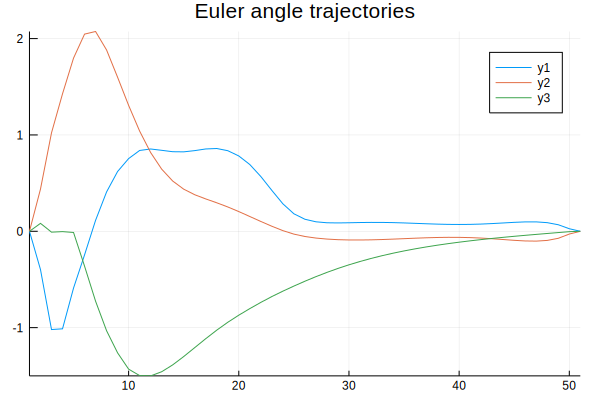

In [83]:
# Plot Euler angle trajectories
eul = zeros(3,solver.N)
for i = 1:solver.N
#     eul[:,i] = TrajectoryOptimization.quat2eul(results.X[4:7,i])
    eul[:,i] = results_euler.X[4:6,i]

end

plot(eul',title=("Euler angle trajectories"))
